# Skin Dataset

In [1]:
# Import packages
from Bias import BIASme, bias_rotate_2D
from Transformations import remove_outliers_lof, trafo_ica
from DensityEstimators import DE_histogram, DE_kde
from IMITATE import IMITATE
from sklearn import model_selection
from scipy import stats
from sklearn import svm
import pandas as pd
import numpy as np
import copy
import warnings
from sklearn import tree
warnings.filterwarnings('ignore')

In [11]:
def loadData_skin(dataset_size=4177):
    url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00229/Skin_NonSkin.txt'
    dataset = pd.read_csv(url, header=None, sep='\t')
    y = dataset[3].to_numpy()
    isInB = np.array([dataset.to_numpy()[i,2]<=170.5 for i in range(len(dataset))])
    isInB = isInB.reshape(len(isInB), 1)
    X = dataset.drop([2,3], axis=1).to_numpy()
    X = np.append(X, isInB, axis=1)
    
    # draw sample
    X, _, y, _ = model_selection.train_test_split(X, y, test_size=0.95)
    
    return X, y

[Text(167.4, 163.07999999999998, 'X[2] <= 170.5\ngini = 0.329\nsamples = 245057\nvalue = [50859, 194198]'),
 Text(83.7, 54.360000000000014, 'gini = 0.113\nsamples = 188091\nvalue = [11358, 176733]'),
 Text(251.10000000000002, 54.360000000000014, 'gini = 0.425\nsamples = 56966\nvalue = [39501, 17465]')]

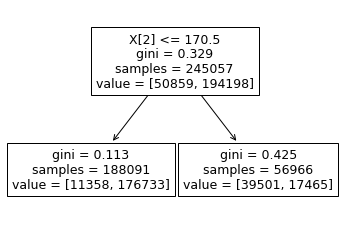

In [8]:
# quick check for the most predictive attribute:
from sklearn import tree
X, y = loadData_skin()
clf = tree.DecisionTreeClassifier(max_depth=1)
clf = clf.fit(X[:,0:len(X[0])-1],y)
tree.plot_tree(clf) 

In [3]:
# remove all mushrooms with rings <= 8
def bias_skin(data, labels):
    isInB = data[:,-1]
    X = data[isInB==1]
    X = X[:, 0:(len(data[0])-1)]
    y = labels[isInB==1]
    return X, y

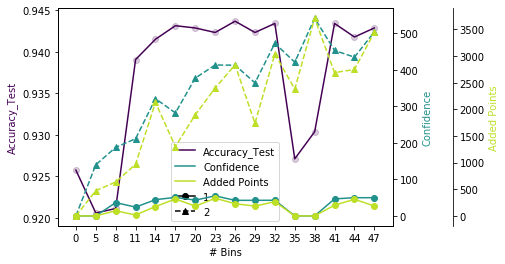

In [4]:
data_gen = loadData_skin
bias_gen = bias_skin
#trafo = lambda: trafo_ica(21)
DE = lambda b: DE_kde(num_bins=b, kernel='gau')
#DE = DE_histogram
bh = IMITATE(list(range(5,50,3)), bias_gen, data_gen, repeat=1, DE=DE, trafo=trafo_ica)
bh.run(False, False, False)

## COMPLETE case: we keep the attribute that we used to create a bias

In [4]:
def run_experiment(num_bins, model, repeat=10):
    DE = lambda b: DE_kde(num_bins=b, kernel='gau')
    data_gen = loadData_skin
    bias_gen = bias_skin
    bh = IMITATE([10], bias_gen, data_gen, repeat=1, model=model, DE=DE, trafo=trafo_ica)
    
    # run 10 times, pick the result with the highest confidence
    max_conf = 0
    for bins in num_bins:
        for i in range(repeat):
            bh.reset()
            label_conf = bh.fill_up(num_bins=bins, iterations=10, fill_up_plots=False, point_plots=False, RO=True)
            #print("run", i, ", conf", label_conf)
            if max(label_conf) >= max_conf:
                max_conf = max(label_conf)
                best_bh = copy.deepcopy(bh)
    return best_bh

In [5]:
def run_and_eval(runs=10, model=svm.SVC(kernel='linear')):
    acc_init = np.zeros(runs)
    acc_final = np.zeros(runs)
    hist_bins = list(range(10,30,1))
    
    for r in range(runs):
        bh = run_experiment(hist_bins, model=model, repeat=2)
        acc_init[r] = bh.D.acc_unbiased - bh.D.acc_init
        acc_final[r] = bh.D.acc_unbiased - bh.D.accuracyBiased(bh.added_points, bh.added_labels)
        print("run", r, "- acc_i =", acc_init[r], " acc_f =", acc_final[r])

    return acc_init, acc_final

### Linear SVM

In [7]:
res = run_and_eval()

run 0 - acc_i = 0.0016322089227421843  acc_f = -0.013601741022850944
run 1 - acc_i = 0.0  acc_f = -0.011153427638737834
run 2 - acc_i = 0.006256800870511392  acc_f = -0.008977149075081625
run 3 - acc_i = 0.005168661588683343  acc_f = 0.0
run 4 - acc_i = 0.004896626768226331  acc_f = -0.014961915125136005
run 5 - acc_i = 0.01088139281828071  acc_f = -0.01088139281828071
run 6 - acc_i = 0.005440696409140355  acc_f = -0.006528835690968404
run 7 - acc_i = -0.007072905331882429  acc_f = -0.018226332970620263
run 8 - acc_i = -0.0002720348204570122  acc_f = -0.01441784548422198
run 9 - acc_i = 0.007072905331882429  acc_f = -0.001360174102285172


In [10]:
np.average(res, axis=1)

array([ 0.00340044, -0.01001088])

In [11]:
stats.ttest_ind(res[0], res[1])

Ttest_indResult(statistic=5.476988967857242, pvalue=3.3464506559047906e-05)

### Decision Tree

In [14]:
model = tree.DecisionTreeClassifier
res_tree = run_and_eval(model=model)

run 0 - acc_i = 0.010065288356909674  acc_f = -0.014689880304678993
run 1 - acc_i = 0.004080522306855294  acc_f = -0.013057671381936808
run 2 - acc_i = 0.005168661588683343  acc_f = 0.0016322089227420733
run 3 - acc_i = -0.0005440696409141355  acc_f = -0.012513601741022895
run 4 - acc_i = 0.0068008705114255275  acc_f = 0.0008161044613710366
run 5 - acc_i = 0.006528835690968515  acc_f = -0.020946681175190385
run 6 - acc_i = 0.016050054406964054  acc_f = 0.005168661588683343
run 7 - acc_i = 0.0021762785636560977  acc_f = -0.014961915125136005
run 8 - acc_i = 0.0  acc_f = -0.007889009793253576
run 9 - acc_i = -0.0002720348204570122  acc_f = -0.008977149075081625


In [15]:
np.average(res_tree, axis=1)

array([ 0.00500544, -0.00854189])

In [16]:
stats.ttest_ind(res_tree[0], res_tree[1])

Ttest_indResult(statistic=4.297292639502206, pvalue=0.00043369257716179775)

### SVM with RBF kernel

In [6]:
model = svm.SVC(kernel='rbf')
res_rbf = run_and_eval(model=model)

run 0 - acc_i = -0.0002720348204570122  acc_f = -0.0016322089227420733
run 1 - acc_i = 0.0043525571273123065  acc_f = -0.002720348204570122
run 2 - acc_i = 0.0010881392818280489  acc_f = -0.015778019586507153
run 3 - acc_i = -0.005440696409140355  acc_f = -0.008705114254624613
run 4 - acc_i = -0.009249183895538637  acc_f = -0.016594124047878078
run 5 - acc_i = 0.007889009793253576  acc_f = -0.005168661588683343
run 6 - acc_i = 0.014145810663764968  acc_f = -0.008705114254624613
run 7 - acc_i = -0.004624591947769319  acc_f = -0.019586507072905324
run 8 - acc_i = 0.00353645266594127  acc_f = -0.016594124047878078
run 9 - acc_i = 0.01088139281828071  acc_f = -0.0010881392818281599


In [9]:
np.average(res_rbf, axis=1)

array([ 0.00223069, -0.00965724])

In [10]:
stats.ttest_ind(res_rbf[0], res_rbf[1])

Ttest_indResult(statistic=3.6775821252456904, pvalue=0.0017225422938838477)